In [23]:
import os
import cooler
import numpy as np
import pandas as pd
from scipy.stats import norm, zscore

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

from itertools import cycle, islice
import xarray as xr
from glob import glob
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#mpl.rcParams['font.family'] = 'sans-serif'
#mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [24]:
#OPC_NN , Scel
#Microglia_NN Dock2
#Astro-NT_NN, Hivep2

In [25]:
ct = 'Oligo_NN'
gtmp = 'Scel'

In [26]:
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:-1]

In [27]:
leg = [f'{ct}.8wk', f'{ct}.18mo']

In [28]:
indir = '/data/female-amb/loop/'
ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
cdir = f'/home/qzeng_salk_edu/project/240204-redo-compartment/Call.DiffComp.CellType.Age/{ct}'

In [29]:
chrom_size_path = f'/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

In [30]:
## Load boundary probability
bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]
bound_prob_ct

,chr1_0,chr1_1,chr1_2,chr1_3,chr1_4,chr1_5,chr1_6,chr1_7,chr1_8,chr1_9,...,chr19_2448,chr19_2449,chr19_2450,chr19_2451,chr19_2452,chr19_2453,chr19_2454,chr19_2455,chr19_2456,chr19_2457
Oligo_NN.8wk,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005988,0.053037,0.005988,0.001711,0.002994,0.003849,0.0,0.0,0.0,1.0
Oligo_NN.18mo,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002566,0.061591,0.007271,0.002994,0.001711,0.001283,0.0,0.0,0.0,1.0


In [31]:
genemeta = pd.read_csv('/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t', index_col = 'gene_name')
genemeta = genemeta[~genemeta.index.duplicated(keep='first')]
genemeta.head()

,chrom,source,feature,start,end,score,strand,phase,gene_id,transcript_id,...,gene_status,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,mgi_id,havana_gene,tag
gene_name,,,,,,,,,,,,,,,,,,,,,
4933401J01Rik,chr1,HAVANA,gene,3073253,3074322,.,+,.,ENSMUSG00000102693.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:1918292,OTTMUSG00000049935.1,NaN
Gm26206,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,ENSMUSG00000064842.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,MGI:5455983,NaN,NaN
Xkr4,chr1,HAVANA,gene,3205901,3671498,.,-,.,ENSMUSG00000051951.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:3528744,OTTMUSG00000026353.2,NaN
Gm18956,chr1,HAVANA,gene,3252757,3253236,.,+,.,ENSMUSG00000102851.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
Gm37180,chr1,HAVANA,gene,3365731,3368549,.,-,.,ENSMUSG00000103377.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:5610408,OTTMUSG00000049960.1,NaN


In [32]:

lslop, rslop = 1000000, 1000000 

chrom = genemeta.loc[gtmp, 'chrom']
if genemeta.loc[gtmp, 'strand']=='+':
    tss = genemeta.loc[gtmp, 'start']
    tes = genemeta.loc[gtmp, 'end']
else:
    tss = genemeta.loc[gtmp, 'end']
    tes = genemeta.loc[gtmp, 'start']

#tss, tes = tss -2000, tes + 2000
ll, rr = (tss - lslop), (tss + rslop)
print(chrom, ll, rr, genemeta.loc[gtmp, 'strand'])

chr14 102513342 104513342 +


In [33]:
## contact maps are plotted at loop resolution
## select region to plot in Q matrix

resl = 10000
loopl, loopr = (ll//resl), (rr//resl)
print(loopl, loopr)

10251 10451


In [34]:

from scipy import ndimage as nd

dstall = []
for ct_age in leg:
    cool = cooler.Cooler(f'{indir}/{ct_age}/{ct_age}/{ct_age}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).tocsr()
    tmp = Q[loopl:loopr, loopl:loopr].toarray()
    dstall.append(tmp)
    print(ct_age)

Oligo_NN.8wk
Oligo_NN.18mo


In [35]:
## select differential loop

loopall = pd.read_hdf(f'{ldir}/merged_loop.hdf', key='data')
sell = ((loopall[0]==chrom) & 
        (zscore(np.log(loopall['Qanova']))>norm.isf(0.15)) & 
        (zscore(np.log(loopall['Tanova']))>norm.isf(0.15)) & 
        (loopall[1]>ll) & (loopall[5]<rr))
print(sell.sum())

4


In [36]:
## select differential boundary
binall = pd.read_hdf(f'{ddir}/{ct}_bin_stats.hdf', key='data')
selb = (binall['chrom']==chrom) & (binall['start']>=ll) & (binall['start']<rr) & binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'] #& binall['bklfilter']
print(selb.sum())

0


In [37]:
## select differential compartment

resc = 100000
comp = pd.read_csv(f'{cdir}/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph', sep='\t', header=0, index_col=None)
comp.index = comp['chr'] + '_' + (comp['start'] // resc).astype(str)
bincomp = comp[['chr', 'start', 'end', 'sample_maha', 'pval', 'padj']]
comp = comp.iloc[:,3:6]
comp = pd.concat([comp.iloc[:,0],comp.iloc[:,1]], axis = 1)
comp.columns = leg
selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr) & (zscore(bincomp['sample_maha'])>norm.isf(0.025))
print(selc.sum())

0


In [38]:
comp = pd.read_csv(f'{cdir}/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph', sep='\t', header=0, index_col=None)

In [16]:
dstall = []
for group in leg:
    cool = cooler.Cooler(f'/data/female-amb/loop/{group}/{group}/{group}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).tocsr()
    tmp = Q[loopl:loopr, loopl:loopr].toarray()
    #dst = nd.rotate(tmp, 45, order=0, reshape=True, prefilter=False, cval=0)
    dstall.append(tmp)

#dstall.append(np.log(dstall[1]/dstall[0]))
dstall.append(dstall[1]-dstall[0])

[Text(-0.5, 0, '102.51M'),
 Text(99.5, 0, 'TSS'),
 Text(199.5, 0, '104.51M'),
 Text(99.5, 0, 'TSS'),
 Text(109.5, 0, 'TES')]

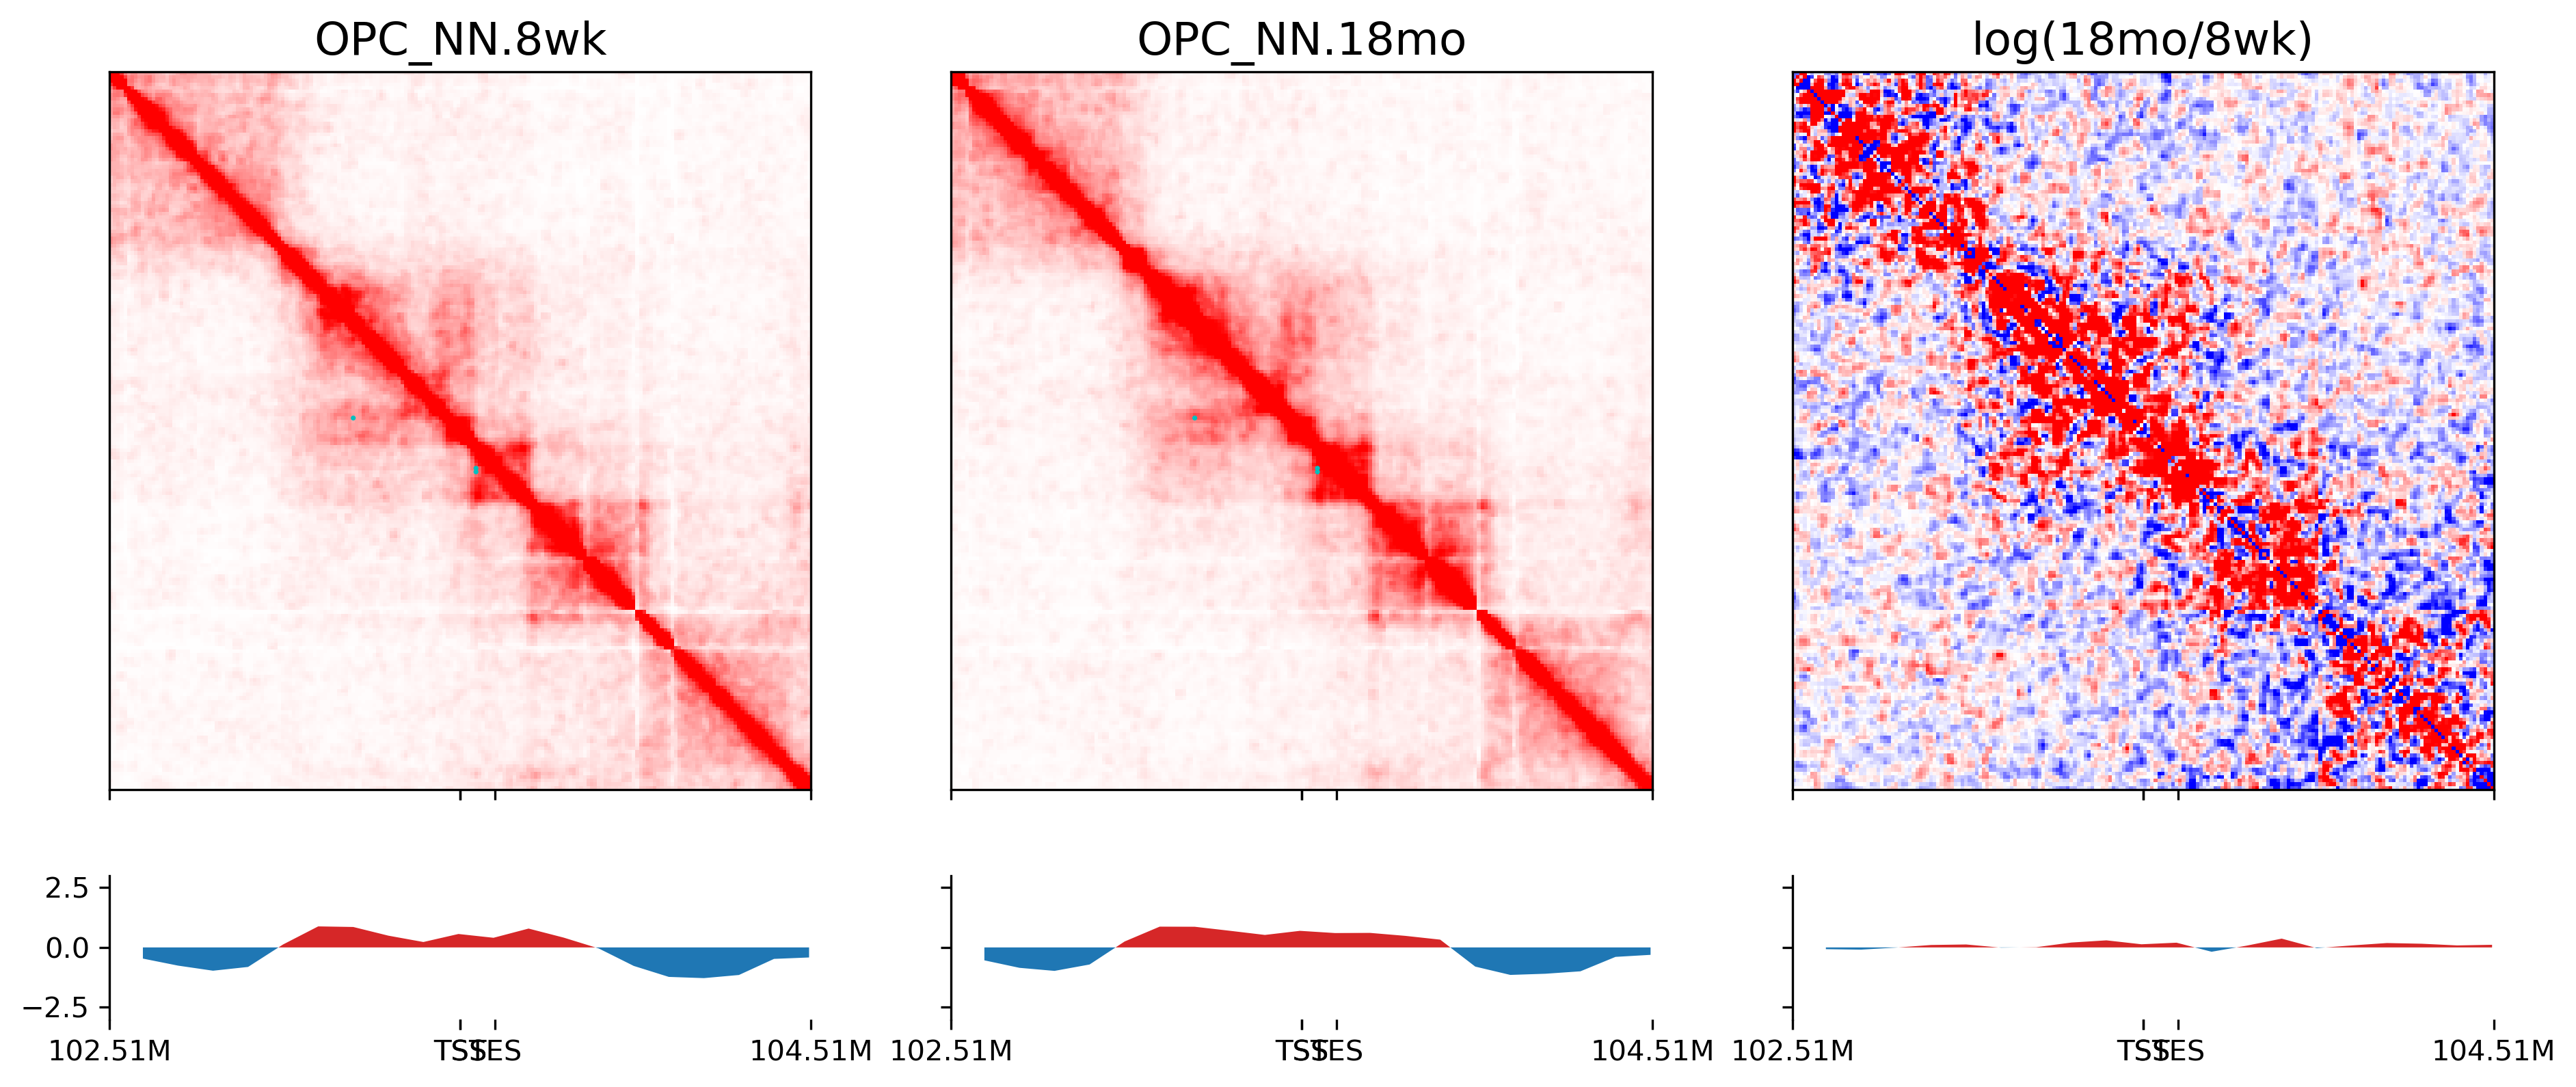

In [18]:
fig, axes = plt.subplots(2, len(leg)+1, figsize=(5*3, 6), sharex='col', sharey='row',
                         gridspec_kw={'height_ratios':[5,1]}, dpi=300)

## differential feature position at 10k resolution
tmpl = loopall.loc[sell, [1,4]].values // resl - loopl
tmpd = binall.loc[selb, 'start'] // resl - loopl
tmpc = bincomp.loc[selc, 'start'] // resl - loopl

for i in range(len(leg)):
    ax = axes[0,i]
    ax.axis('equal')
    ax.set_title(leg[i], fontsize=16)
    #value = 0.02
    if i == 0:
        value = 0.01
    elif i == 1:
        value = 0.01
    img = ax.imshow(dstall[i], cmap='bwr', vmin=-value, vmax=value, aspect='auto')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ## plot diff loop
    ax.scatter(tmpl[:, 0], tmpl[:, 1], alpha=1, s=3, marker='o', edgecolors='none', color='c')
    
    ax = axes[1,i]
    sns.despine(bottom=True, ax=ax)
    ## plot compartment, use 10k coordinate
    sel = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr)
    x = bincomp.loc[sel, 'start'] // resl - loopl
    y = comp.loc[sel, leg[i]].values
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ## plot diff comp
    ax.scatter(tmpc, np.zeros(len(tmpc)), color='r', s=4)
    ax.set_ylim([-3, 3])
    ax.set_xlim([-0.5, loopr-loopl-0.5])
    ax.set_xticks(np.arange(-0.5, loopr-loopl, 100).tolist() + [tss//resl-loopl-0.5, tes//resl-loopl-0.5])
    ax.set_xticklabels([])
    ax.set_xticklabels([f'{(xx+loopl)/100}M' for xx in np.arange(0, loopr-loopl+1, 100)]+['TSS','TES'])

i = 2
ax = axes[0,i]
ax.axis('equal')
ax.set_title('log(18mo/8wk)', fontsize=16)
img = ax.imshow(dstall[i], cmap='bwr',  vmin=-0.001, vmax=0.001, aspect='auto') #  vmin=-2, vmax=2
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
## plot diff loop
# ax.scatter(tmpl[:, 0], tmpl[:, 1], alpha=1, s=6, marker='o', edgecolors='none', color='c')

ax = axes[1,i]
sns.despine(bottom=True, ax=ax)
## plot compartment, use 10k coordinate
sel = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr)
x = bincomp.loc[sel, 'start'] // resl - loopl
y = comp.loc[sel, leg[1]].values - comp.loc[sel, leg[0]].values
ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
## plot diff comp
ax.scatter(tmpc, np.zeros(len(tmpc)), color='r', s=4)
ax.set_ylim([-3, 3])
ax.set_xlim([-0.5, loopr-loopl-0.5])
ax.set_xticks(np.arange(-0.5, loopr-loopl, 100).tolist() + [tss//resl-loopl-0.5, tes//resl-loopl-0.5])
ax.set_xticklabels([])
ax.set_xticklabels([f'{(xx+loopl)/100}M' for xx in np.arange(0, loopr-loopl+1, 100)]+['TSS','TES'] )

#plt.savefig(f'figure/{ct}_diff_{gtmp}.pdf', transparent=True, dpi=300)

In [20]:
tmp = dstall[2]

In [22]:
tmp.shape

(200, 200)

In [37]:
top_left_square = tmp[:40, :40] *10000
top_left_square.mean()

4.1494036

In [38]:
cemter_square = tmp[40:140, 40:140] *10000
cemter_square.mean()

3.214471

In [39]:
bottom_right_square = tmp[140:200, 140:200] *10000
bottom_right_square.mean()

0.5642158

In [44]:
bottom_left_square = tmp[0:40, 140:200] *10000
bottom_left_square.mean()

-0.13316786

In [45]:
top_rectangle = tmp[0:40, 40:140] *10000
bottom_left_square.mean()

-0.13316786

In [42]:
bottom_rectangle = tmp[40:140, 60:200] *10000
bottom_rectangle.mean()

1.9761486

In [25]:
sel = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr)
x = bincomp.loc[sel, 'start'] // resl - loopl
y = comp.loc[sel, leg[1]].values

In [ ]:
## left 40
## middle 100
## right 60